# 5. Modelo - Backteste e Treino


Aqui contêm a manipulação final dos dados para treino e avaliação do modelo.

Contêm as etapas de Split, Resample, Desenvolvimento do modelo e Avaliação do resultado.



In [27]:
# Bibliotecas
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
import shap
import pickle
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from babel.numbers import format_currency # conversão de float para moeda local
from IPython.display import Image # Exibir imagem com resultado

In [28]:
# variável para teste de resample
resample_selection = 'over' # 'over' ou 'under'

# Não utilizar notação cientifica para melhorar a visualização
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# Carrega dados
df = pd.read_csv('../data/3_primary/df_to_model.csv')

df


,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,VALOR_A_PAGAR,TAXA,INADIMPLENTE,DIAS_EMISSAO_VENCIMENTO,DDD,FLAG_PF,PORTE,CEP_2_DIG,...,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,SEGMENTO_INDUSTRIAL_nan,DOMINIO_EMAIL_AOL,DOMINIO_EMAIL_BOL,DOMINIO_EMAIL_GMAIL,DOMINIO_EMAIL_HOTMAIL,DOMINIO_EMAIL_OUTLOOK,DOMINIO_EMAIL_YAHOO,DOMINIO_EMAIL_nan
0,16913.00,92.00,22427.25,5.99,0,22,68,1,2,55,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,16913.00,92.00,35608.11,5.99,0,22,68,1,2,55,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,236447.00,93.00,17988.49,5.99,0,21,68,1,2,55,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,236447.00,93.00,41998.20,6.99,0,20,68,1,2,55,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,236447.00,93.00,35514.41,6.99,0,22,68,1,2,55,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73432,343507.00,134.00,17302.05,4.99,0,45,0,1,1,26,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
73433,392975.00,121.00,19799.30,6.99,0,15,0,1,2,3,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
73434,392975.00,121.00,19913.15,11.99,0,15,0,1,2,3,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
73435,70449.00,141.00,2806.09,6.99,0,25,9,1,1,10,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


****
### Dados para validação

Separação de uma parte do dataset para validação do modelo.

In [29]:
# Porcentagem de amostras para treino e teste (90%) e validação (10%)
percent = 0.9

# Separação em duas partes
df_treino_teste = df.sample(frac=percent, random_state=42)
df_validacao = df.drop(df_treino_teste.index)

print(f"len_treino_teste: {len(df_treino_teste)}  |  len_validacao: {len(df_validacao)}")

df = df_treino_teste

len_treino_teste: 66093  |  len_validacao: 7344


****
### Split

In [30]:
target = "INADIMPLENTE"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (66093, 41)
y shape: (66093,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (52874, 41)
y_train shape: (52874,)
X_test shape: (13219, 41)
y_test shape: (13219,)


****
### Resample

Como temos um dataset desbalanceado (muito mais registros de NÃO INADIMPLENCIA do que com INADIMPLENCIA), serão avaliadas as técnicas de Oversample e Undersample.
- Oversample: atribuição de dados com mesma distribuição dos dados já contidos
- Undersample: amostragem de valores aleatórios dentro da classe majoritária

A título de verificação, será aplicado resample também na base de teste.

In [32]:
print(f"X_train: original: {X_train.shape}")
      
over_sampler_train = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler_train.fit_resample(X_train, y_train)
print(f"\tover shape: {X_train_over.shape}")

under_sampler_train = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler_train.fit_resample(X_train, y_train)
print(f"\tunder shape: {X_train_under.shape}")


# Atribui para variável geral para facilitar a comutação nos testes
X_train_resampled, y_train_resampled = (X_train_over, y_train_over) if resample_selection == 'over' else (X_train_under, y_train_under)

X_train: original: (52874, 41)
	over shape: (98400, 41)
	under shape: (7348, 41)


In [33]:
y_train_resampled.value_counts(normalize=True)

0   0.50
1   0.50
Name: INADIMPLENTE, dtype: float64

****
### Análise do subdataset de teste em termos financeiro, para posterior comparação com resultado

Para ajudar na comunicação do resultado, tomei a parte de teste do modelo, do dataset de desenvolvimento, e analisei o prejuízo dos empréstimos que foram concedidos.

Ao final desse notebook, recuperarei esses dados e compararei com os resultados obtidos pelo modelo sobre os mesmos dados.

In [34]:
df_test = X_test.reset_index().merge(y_test.reset_index(), on='index')
df_test['INADIMPLENTE'] = df_test['INADIMPLENTE'].astype(int)


tamanho_base = len(df_test)
qtd_inadimp = len(df_test[df_test['INADIMPLENTE'] == 1])
porcent_inadimp = (len(df_test[df_test['INADIMPLENTE'] == 1]) / len(df_test)) 
valor_medio = df_test['VALOR_A_PAGAR'].mean()
prejuizo = tamanho_base * porcent_inadimp * valor_medio
valor_total = df_test['VALOR_A_PAGAR'].sum()


print(f'Tamanho da base: {tamanho_base}')
print(f'Quantidade de processos inadimplentes: {qtd_inadimp}')
print('% de processos inadimplentes: {:.2f} %'.format(porcent_inadimp * 100))
print(f"Valor médio: {format_currency(valor_medio, 'BRL', locale='pt_BR')}")
print(f"Valor total: {format_currency(valor_total, 'BRL', locale='pt_BR')}")
print(f"Prejuízo: {format_currency(prejuizo, 'BRL', locale='pt_BR')}")


Tamanho da base: 13219
Quantidade de processos inadimplentes: 915
% de processos inadimplentes: 6.92 %
Valor médio: R$ 46.481,19
Valor total: R$ 614.434.887,39
Prejuízo: R$ 42.530.291,40


****
### Baseline

In [35]:
# Valor do Baseline Line - metrica a ser batida pelo modelo 
acc_baseline = y_train.value_counts(normalize=True).max()
print("Acurácia a ser batida pelo modelo: ", round(acc_baseline, 4))

Acurácia a ser batida pelo modelo:  0.9305


****
### Tunning de hiperparâmetros - XGBoost

Optei pela utilização de um modelo baseado em árvores de decisão, pois fornece maior explicabilidade das predições.

Embora em algum cenário possa haver modelos com melhor performance, optei por maior explicabilidade em detrimento da performance por se tratar de uma área sensível que é a liberação (ou não) de crédito e para atender as regulamentações sobre o processo decisório do modelo.

In [10]:
# Define o range dos parâmetros a serem testados
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [5, 7, 9],
    'n_estimators': [100, 200, 300]
}

# Cria o modelo XGBoost
model = xgb.XGBClassifier()

# Cria o objeto GridSearchCV para realizar a busca pelos melhores parâmetros
print("Executando GridSearch...")
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='recall')

# Ajusta o modelo aos dados de treinamento
grid_search.fit(X_train_resampled, y_train_resampled)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Obtem a melhor pontuação (score) alcançada durante a busca
print("Melhor pontuação:", grid_search.best_score_)

# Avalia o modelo nos dados de teste
accuracy = grid_search.score(X_test, y_test)
print("Acurácia no conjunto de teste:", accuracy)

# Fit com os melhores parametros
print("Fitando com melhores parametros...")
model_xgb = xgb.XGBClassifier(**grid_search.best_params_)
model_xgb.fit(X_train_resampled, y_train_resampled)

Executando GridSearch...
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
Melhor pontuação: 1.0
Acurácia no conjunto de teste: 0.8109289617486338
Fitando com melhores parametros...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [36]:
acc_train = model_xgb.score(X_train, y_train)
acc_test = model_xgb.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9982
Test Accuracy: 0.9653


In [37]:
print(classification_report(y_test, model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     12304
           1       0.72      0.81      0.76       915

    accuracy                           0.97     13219
   macro avg       0.85      0.89      0.87     13219
weighted avg       0.97      0.97      0.97     13219



****
#### Curva ROC

A curva ROC (Receiver Operating Characteristic) é uma representação gráfica da performance de um modelo de classificação binária em diferentes limiares de classificação. A interpretação da curva ROC envolve analisar o trade-off entre a taxa de verdadeiros positivos (sensibilidade) e a taxa de falsos positivos (especificidade).

Algumas considerações importantes ao interpretar a curva ROC:

- Quanto mais próximo a curva ROC estiver do canto superior esquerdo do gráfico, melhor será o desempenho do modelo, indicando uma maior capacidade de distinguir entre as classes positiva e negativa.
- A diagonal da curva ROC representa o desempenho de um classificador aleatório, onde a taxa de verdadeiros positivos é igual à taxa de falsos positivos. Portanto, qualquer modelo que esteja acima dessa diagonal é considerado melhor do que um classificador aleatório.
- Quanto maior a área sob a curva ROC (AUC-ROC), melhor o desempenho do modelo. A AUC-ROC varia de 0 a 1, sendo que um valor de 0,5 indica um modelo que possui um desempenho equivalente ao acaso, e um valor próximo de 1 indica um modelo com alta capacidade de discriminação entre as classes.

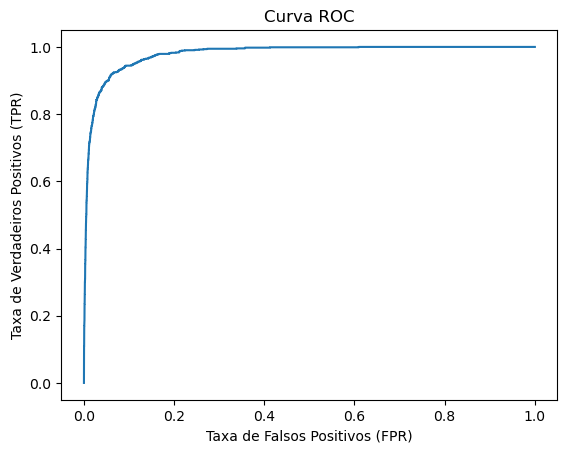

AUC-ROC: 0.9792767645867531


In [38]:
# Obtém as probabilidades preditas do modelo
probabilidades = model_xgb.predict_proba(X_test)[:, 1]

# Calcula o FPR, TPR e os limiares
fpr, tpr, thresholds = roc_curve(y_test, probabilidades)

# Plota a curva ROC
plt.plot(fpr, tpr)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.show()

# Calcula a AUC-ROC
auc_roc = roc_auc_score(y_test, probabilidades)
print('AUC-ROC:', auc_roc)

****
### Interpretação dos resultados em termos financeiros

Falso Negativo: 1.31 % 


Considerando o valor médio dos empréstimos da base de teste (R$ 46.481,00), com o modelo proposto temos que:

1- O valor emprestado aos clientes que NÃO seriam inadimplentes (cenário + seguro) foi de R$ 558.608.658,00;
2- O valor NÃO emprestado aos clientes que seriam inadimplentes (escolha certa - lucro) foi de R$ 34.488.902,00;
3- O valor emprestado aos clientes que seriam inadimplentes (escolha errada - perda) foi de R$ 8.041.213,00;
4- O valor NÃO emprestado aos clientes que NÃO seriam inadimplentes (perda de oportunidade) foi de R$ 13.293.566,00.



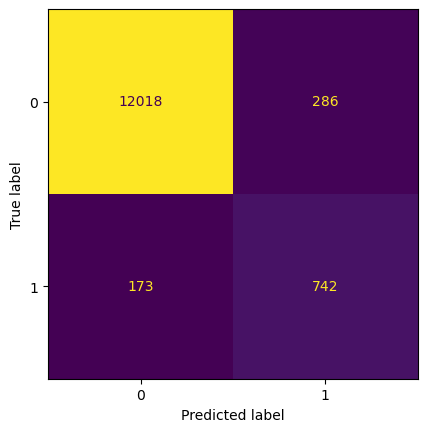

In [39]:
threshold = 0.5 # ponto de corte para considerar o valor da probabilidade como True (inadimplente) ou False (não inadimplente)
y_pred_proba = model_xgb.predict_proba(X_test)[:, -1]
y_pred = y_pred_proba > threshold
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

falso_negativo = (fn / (tn + fp + fn + tp)) * 100
print(f'Falso Negativo: {round(falso_negativo, 2)} % \n')

# Valor médio dos empréstimos na base de teste
valor_medio_emprestimo_X_teste = int(X_test['VALOR_A_PAGAR'].mean())

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False);

nao_destaca = "\033[1m\x1B[4mNÃO\x1B[0m\033[0m"
print(f"""
Considerando o valor médio dos empréstimos da base de teste ({format_currency(valor_medio_emprestimo_X_teste, 'BRL', locale='pt_BR')}), com o modelo proposto temos que:

1- O valor emprestado aos clientes que {nao_destaca} seriam inadimplentes (cenário + seguro) foi de {format_currency(tn * valor_medio_emprestimo_X_teste, 'BRL', locale='pt_BR')};
2- O valor {nao_destaca} emprestado aos clientes que seriam inadimplentes (escolha certa - lucro) foi de {format_currency(tp * valor_medio_emprestimo_X_teste, 'BRL', locale='pt_BR')};
3- O valor emprestado aos clientes que seriam inadimplentes (escolha errada - perda) foi de {format_currency(fn * valor_medio_emprestimo_X_teste, 'BRL', locale='pt_BR')};
4- O valor {nao_destaca} emprestado aos clientes que {nao_destaca} seriam inadimplentes (perda de oportunidade) foi de {format_currency(fp * valor_medio_emprestimo_X_teste, 'BRL', locale='pt_BR')}.
""")



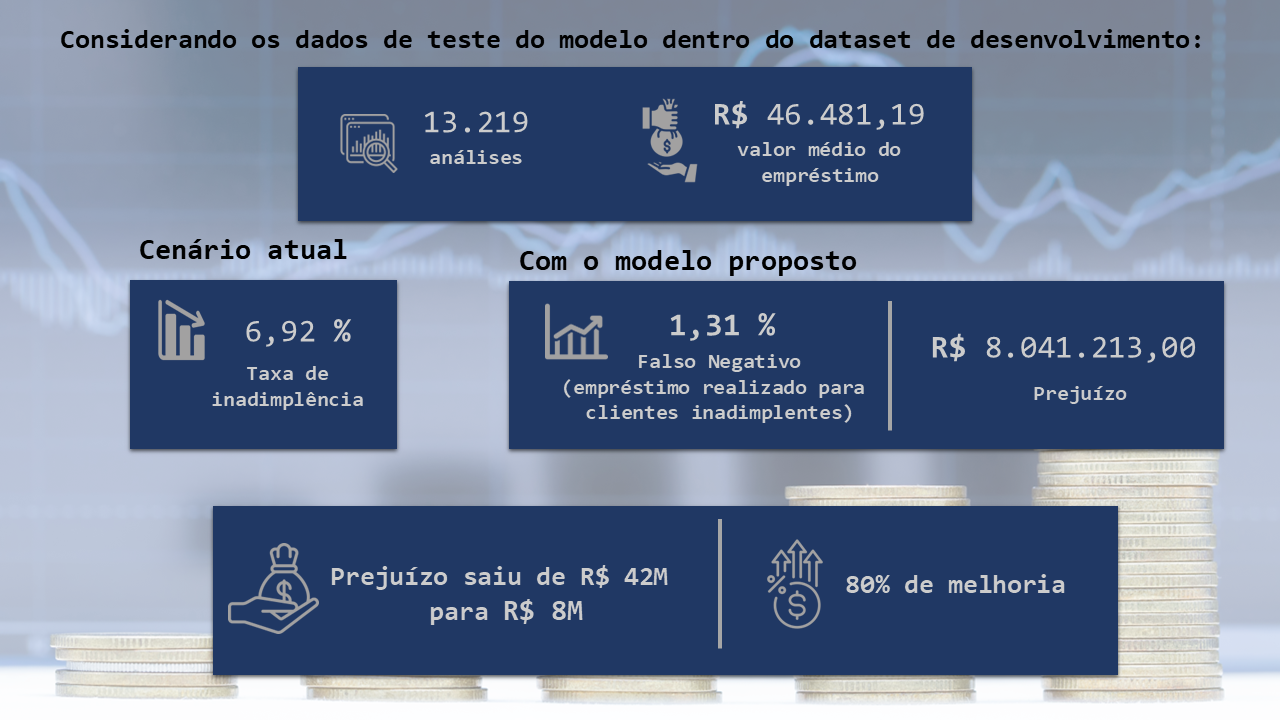

In [40]:
# Para expressar melhor o resultado obtido
Image(filename = "../docs/interpretacao_resultado.png", width=1200)

****
### Teste sobre a base de validação


In [41]:
df_validacao_to_pred = df_validacao.drop(columns='INADIMPLENTE')
df_validacao_to_test = df_validacao['INADIMPLENTE']

df_validacao['PREDICT'] = model_xgb.predict(df_validacao_to_pred)

df_validacao

,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,VALOR_A_PAGAR,TAXA,INADIMPLENTE,DIAS_EMISSAO_VENCIMENTO,DDD,FLAG_PF,PORTE,CEP_2_DIG,...,SEGMENTO_INDUSTRIAL_Serviços,SEGMENTO_INDUSTRIAL_nan,DOMINIO_EMAIL_AOL,DOMINIO_EMAIL_BOL,DOMINIO_EMAIL_GMAIL,DOMINIO_EMAIL_HOTMAIL,DOMINIO_EMAIL_OUTLOOK,DOMINIO_EMAIL_YAHOO,DOMINIO_EMAIL_nan,PREDICT
2,236447.00,93.00,17988.49,5.99,0,21,68,1,2,55,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
28,385018.00,98.00,21512.90,8.99,0,20,68,1,2,55,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
55,138792.00,93.00,20907.76,6.99,0,22,68,1,2,55,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
60,543964.00,98.00,17877.77,6.99,0,20,68,1,2,55,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
66,477417.00,100.00,19204.49,5.99,0,22,68,1,2,55,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73383,89358.00,120.00,240120.00,6.99,0,30,43,1,1,68,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
73400,184391.00,117.00,95125.12,4.99,0,16,51,1,2,34,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
73407,5342.00,1.00,14097.75,8.99,1,36,0,0,2,19,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1
73422,80776.00,161.00,6333.69,11.99,1,20,0,1,1,40,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1


In [42]:
print(classification_report(df_validacao['INADIMPLENTE'], df_validacao['PREDICT']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6821
           1       0.73      0.82      0.77       523

    accuracy                           0.97      7344
   macro avg       0.86      0.90      0.88      7344
weighted avg       0.97      0.97      0.97      7344



****
### Análise das features do modelo

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


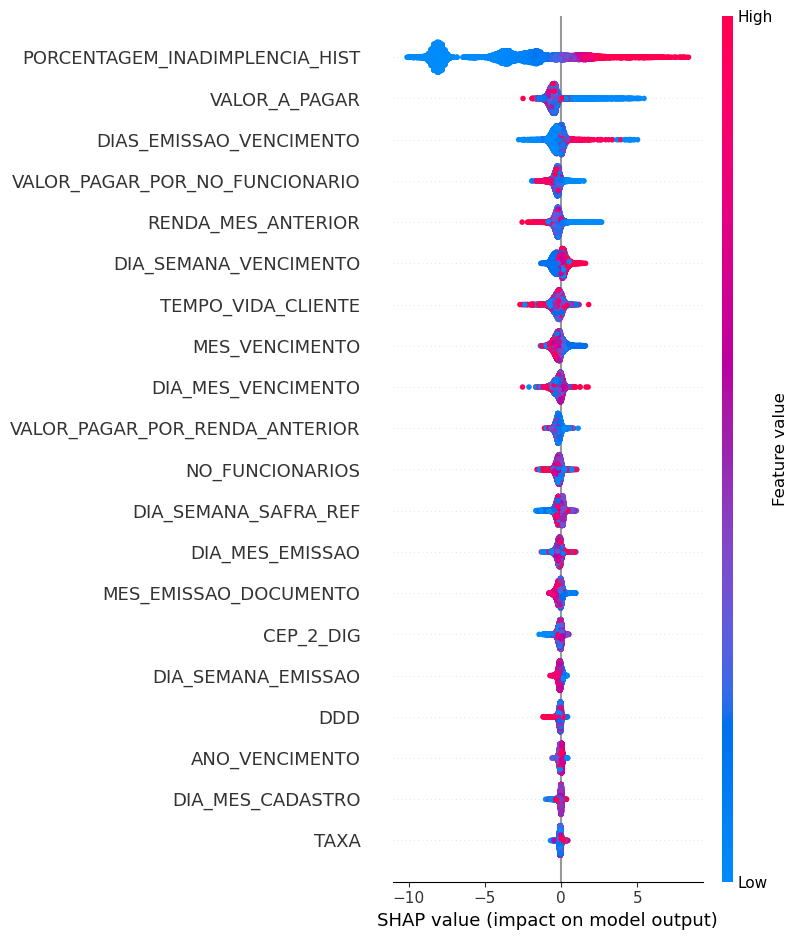

In [43]:
# Análise das features do modelo
shap_values_total = shap.TreeExplainer(model_xgb).shap_values(X_test)
shap.summary_plot(shap_values_total, X_test)#, plot_type="bar")

explainer = shap.TreeExplainer(model_xgb)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)


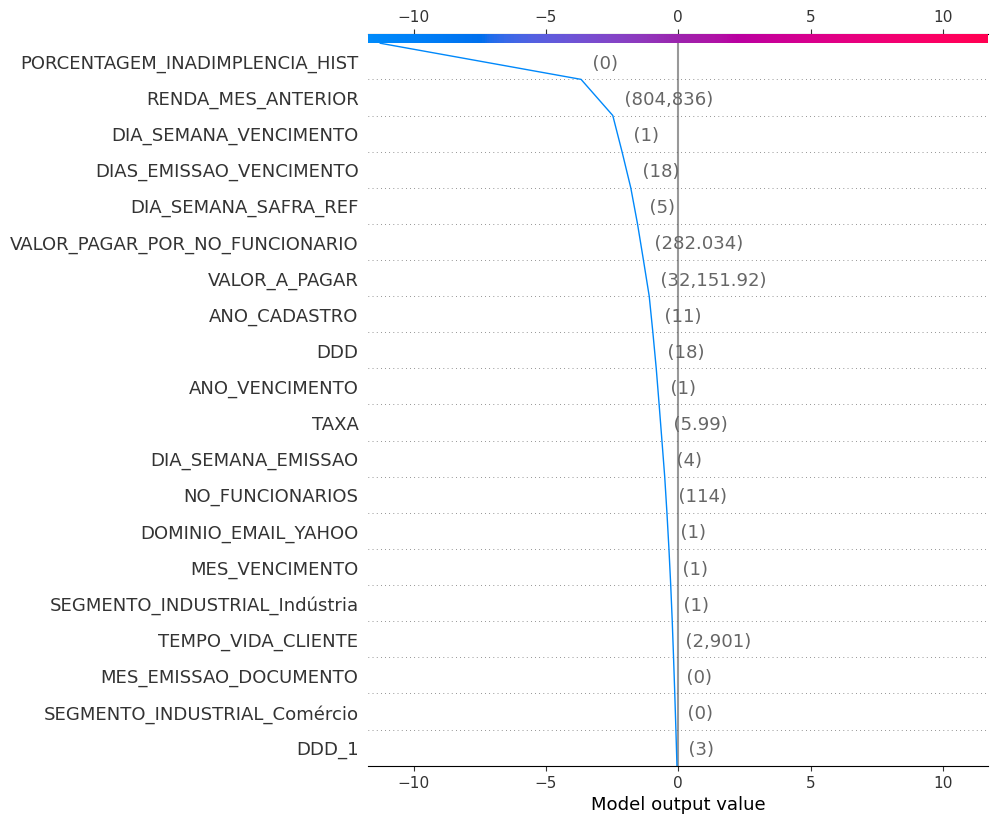

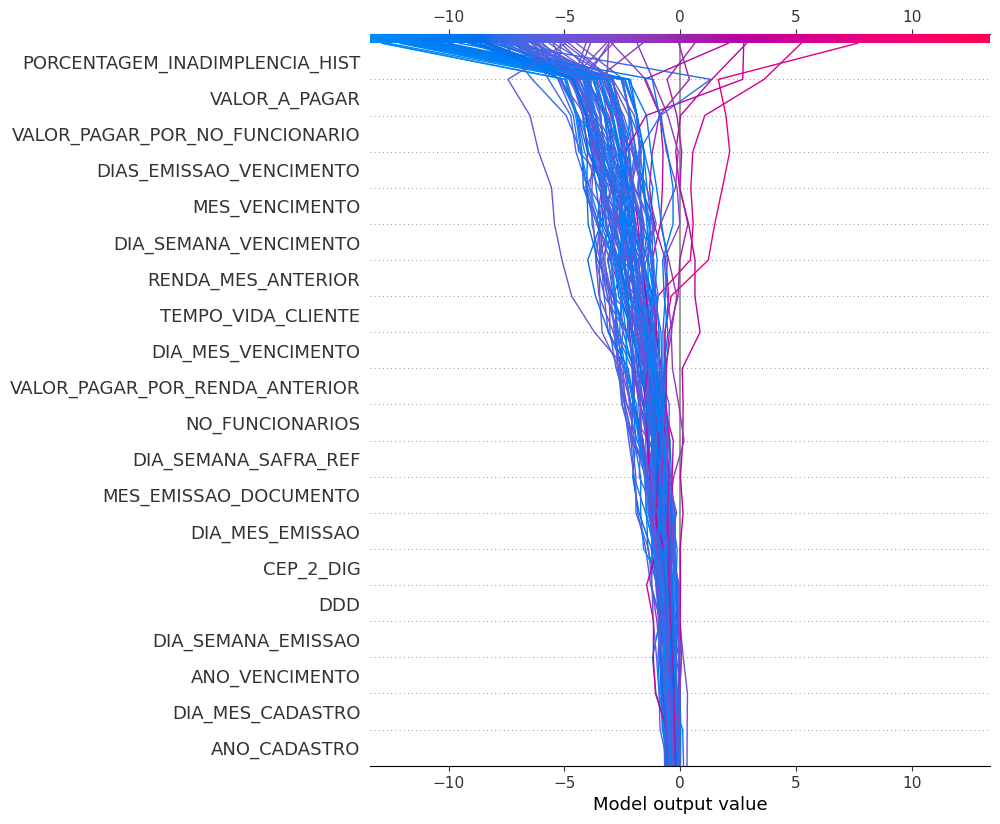

In [44]:
# Setar amostra para visualizar o grafico
amostra = 10
shap.decision_plot(expected_value, shap_values[amostra], X_test.iloc[amostra])
shap.decision_plot(expected_value, shap_values[:100], X_test.iloc[:100])

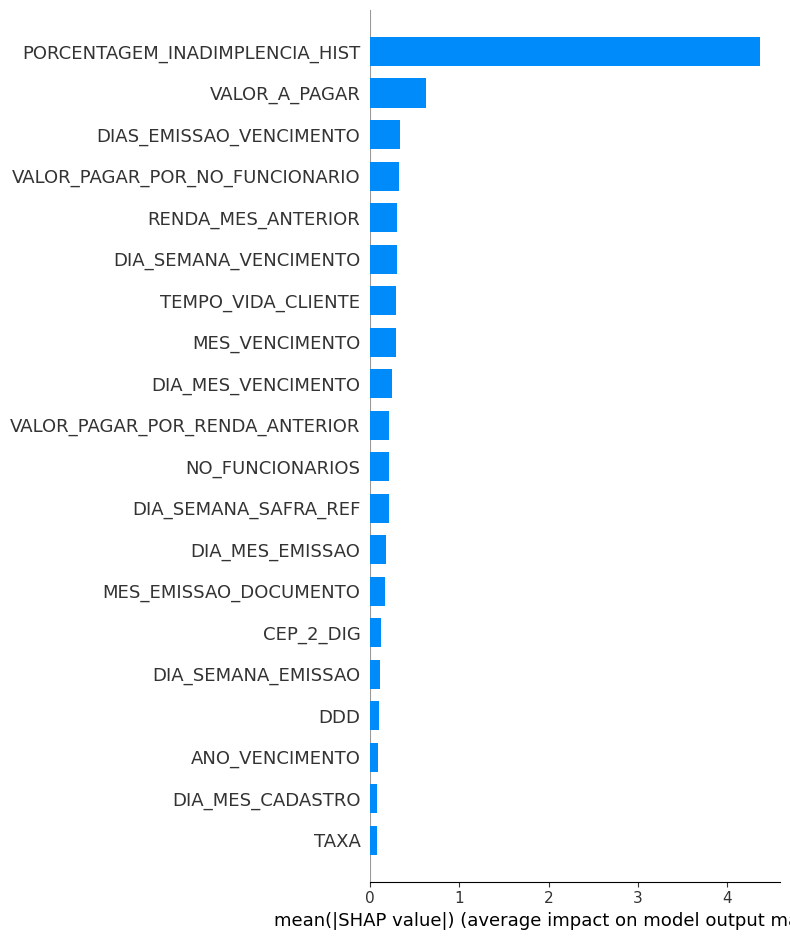

In [45]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

****
### Feature importance

In [46]:
feature_importances = model_xgb.feature_importances_
feature_names = X.columns.tolist()

sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

cumsum = 0
idx = 0
for name, importance in sorted_features:
    cumsum += importance
    if cumsum < 0.99:
        idx += 1
        print(f"{idx} - {name}: \t{round(importance*100, 2)} %")
    else:
        break

1 - PORCENTAGEM_INADIMPLENCIA_HIST: 	35.02 %
2 - VALOR_A_PAGAR: 	5.06 %
3 - MES_VENCIMENTO: 	3.8 %
4 - DIA_SEMANA_SAFRA_REF: 	3.68 %
5 - ANO_VENCIMENTO: 	2.32 %
6 - DIAS_EMISSAO_VENCIMENTO: 	2.28 %
7 - DOMINIO_EMAIL_BOL: 	2.26 %
8 - ANO_EMISSAO_DOCUMENTO: 	2.23 %
9 - DOMINIO_EMAIL_YAHOO: 	1.91 %
10 - DOMINIO_EMAIL_nan: 	1.91 %
11 - DDD: 	1.91 %
12 - MES_EMISSAO_DOCUMENTO: 	1.9 %
13 - SEGMENTO_INDUSTRIAL_Comércio: 	1.88 %
14 - DOMINIO_EMAIL_OUTLOOK: 	1.81 %
15 - MES_CADASTRO: 	1.67 %
16 - DDD_1: 	1.65 %
17 - SEGMENTO_INDUSTRIAL_Indústria: 	1.64 %
18 - SEGMENTO_INDUSTRIAL_nan: 	1.64 %
19 - DIA_SEMANA_CADASTRO: 	1.63 %
20 - DOMINIO_EMAIL_AOL: 	1.63 %
21 - DIA_SEMANA_VENCIMENTO: 	1.6 %
22 - NO_FUNCIONARIOS: 	1.54 %
23 - TEMPO_VIDA_CLIENTE: 	1.53 %
24 - CEP_2_DIG: 	1.48 %
25 - DOMINIO_EMAIL_GMAIL: 	1.4 %
26 - PORTE: 	1.39 %
27 - VALOR_PAGAR_POR_NO_FUNCIONARIO: 	1.39 %
28 - DIA_MES_EMISSAO: 	1.39 %
29 - DIA_MES_CADASTRO: 	1.37 %
30 - RENDA_MES_ANTERIOR: 	1.35 %
31 - DIA_MES_VENCIMENTO: 	1.34

****
## Armazena modelo

In [47]:
# Salvando o modelo em um arquivo pickle
with open('../model/model.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

****
## Conclusão

- Apesar de haverem muitas variáveis com baixa relevância para o modelo, optei por manter todas pois não são variáveis de desenvolvimento complexo e não impactam o tempo de processamento de predição.
- Separação do dataset de desenvolvimento em treino (70%), teste (20%) e validação (10%).
- Resample usando OverRandom
- Manteve o resultado com os dados de validação
- Em ordem, as variáveis mais importantes foram:
    - PORCENTAGEM_INADIMPLENCIA_HIST
    - VALOR_A_PAGAR
    - MES_VENCIMENTO
    - DIA_SEMANA_SAFRA_REF
- Em termos financeiros, os resultados foram:
    - O valor emprestado aos clientes que NÃO seriam inadimplentes (cenário + seguro) foi de R$ 558.608.658,00;
    - O valor NÃO emprestado aos clientes que seriam inadimplentes (escolha certa - lucro) foi de R$ 34.488.902,00;
    - O valor emprestado aos clientes que seriam inadimplentes (escolha errada - perda) foi de R$ 8.041.213,00;
    - O valor NÃO emprestado aos clientes que NÃO seriam inadimplentes (perda de oportunidade) foi de R$ 13.293.566,00.

